In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from librosa import display
from pydub import AudioSegment, effects
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/PDS-Project/speech-emotion-recognition-ravdess-data/'

In [ ]:
def extract_features(file_path,max_length=100):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=20)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr,n_bands=6)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=20)
    zcr=librosa.feature.zero_crossing_rate(y=y)
    rms=librosa.feature.rms(y=y)
    features = np.vstack([mfcc, chroma, spectral_contrast, mel_spectrogram,zcr,rms])
    padded_features = np.zeros((features.shape[0], max_length))
    padded_features[:, :min(features.shape[1], max_length)] = features[:, :min(features.shape[1], max_length)]
    return padded_features

In [ ]:
features_list = []
labels_list = []

for dir in os.listdir(data_path):
    actor = os.listdir(data_path + dir)
    print(f"Directory: {dir}, Number of Files: {len(actor)}")
    for file in actor:
      if file.endswith('.wav'):
        file_path = os.path.join(data_path + dir+ '/'+ file)
        emotion_code = int(file.split('-')[2])-1
        features = extract_features(file_path)
        features_list.append(features)
        labels_list.append(emotion_code)

X = np.array(features_list)
y = np.array(labels_list)

Directory: Actor_24, Number of Files: 60
Directory: Actor_22, Number of Files: 60
Directory: Actor_09, Number of Files: 60
Directory: Actor_01, Number of Files: 60
Directory: Actor_08, Number of Files: 60
Directory: Actor_06, Number of Files: 60
Directory: Actor_07, Number of Files: 60
Directory: Actor_13, Number of Files: 60
Directory: Actor_23, Number of Files: 60
Directory: Actor_19, Number of Files: 60
Directory: Actor_03, Number of Files: 60
Directory: Actor_04, Number of Files: 60
Directory: Actor_15, Number of Files: 60
Directory: Actor_12, Number of Files: 60
Directory: Actor_10, Number of Files: 60
Directory: Actor_21, Number of Files: 60
Directory: Actor_17, Number of Files: 60
Directory: Actor_02, Number of Files: 60
Directory: Actor_05, Number of Files: 60
Directory: Actor_18, Number of Files: 60
Directory: Actor_11, Number of Files: 60
Directory: Actor_16, Number of Files: 60
Directory: Actor_20, Number of Files: 60
Directory: Actor_14, Number of Files: 60


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3))
model.add(LayerNormalization())
model.add(Dense(units=len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
36/36 [==============================] - 7s 113ms/step - loss: 13.1011 - accuracy: 0.2552 - val_loss: 8.5929 - val_accuracy: 0.2935
Epoch 2/100
36/36 [==============================] - 5s 128ms/step - loss: 6.0995 - accuracy: 0.3264 - val_loss: 4.6427 - val_accuracy: 0.2637
Epoch 3/100
36/36 [==============================] - 4s 103ms/step - loss: 3.4916 - accuracy: 0.3628 - val_loss: 3.2109 - val_accuracy: 0.2637
Epoch 4/100
36/36 [==============================] - 3s 92ms/step - loss: 2.5639 - accuracy: 0.3759 - val_loss: 2.6918 - val_accuracy: 0.2338
Epoch 5/100
36/36 [==============================] - 3s 89ms/step - loss: 2.2197 - accuracy: 0.3880 - val_loss: 2.4698 - val_accuracy: 0.1692
Epoch 6/100
36/36 [==============================] - 5s 151ms/step - loss: 2.0115 - accuracy: 0.3984 - val_loss: 2.3284 - val_accuracy: 0.2736
Epoch 7/100
36/36 [==============================] - 4s 102ms/step - loss: 1.9026 - accuracy: 0.4253 - val_loss: 2.2275 - val_accuracy: 0.2836


7/7 [==============================] - 0s 33ms/step - loss: 3.7254 - accuracy: 0.3234
Validation Loss: 3.7254176139831543, Validation Accuracy: 0.323383092880249


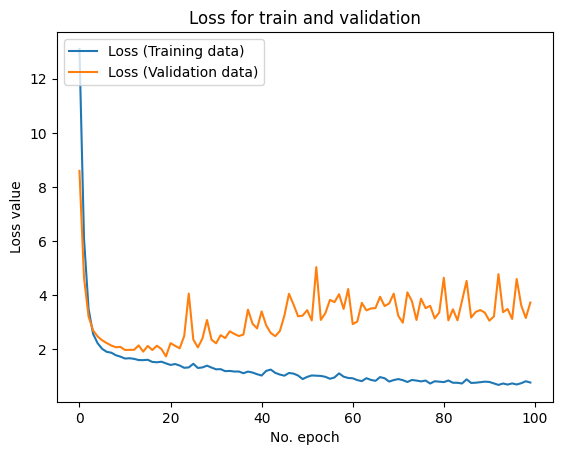

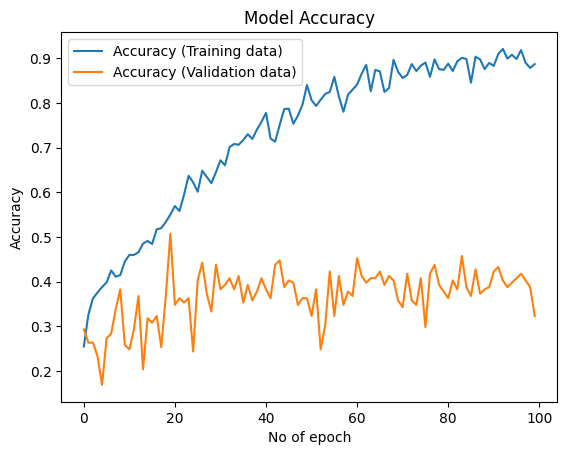

7/7 [==============================] - 1s 36ms/step
Validation set predicted emotions accuracy:
neutral : 0.5000
calm : 0.1304
happy : 0.2500
sad : 0.2308
angry : 0.3462
fearful : 0.5769
disgust : 0.3200
surprised : 0.3448


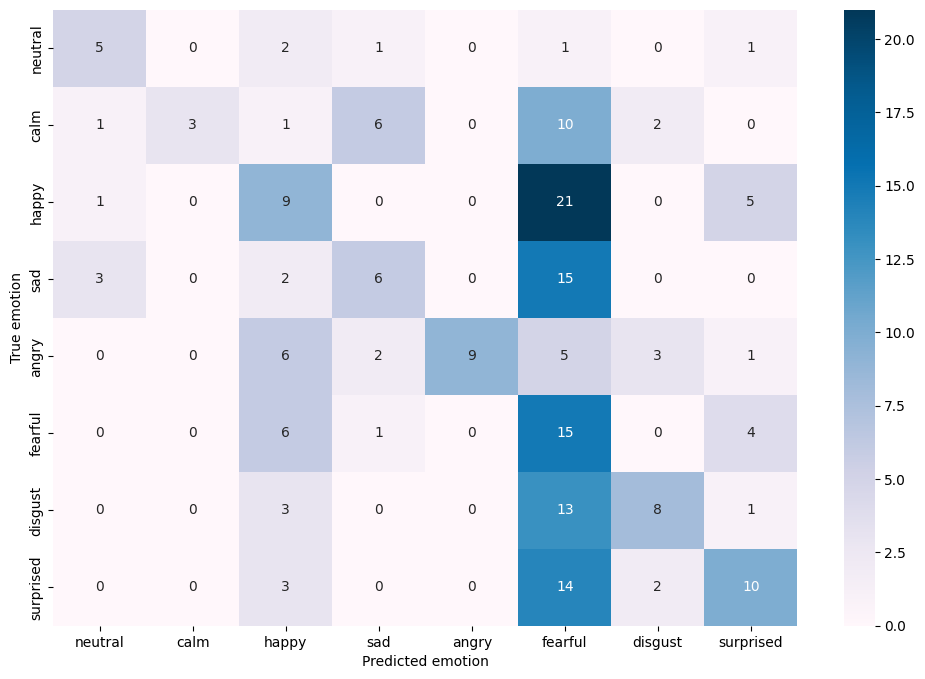

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

plt.plot(history.history['loss'], label='Loss (Training data)')
plt.plot(history.history['val_loss'], label='Loss (Validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


plt.plot(history.history['accuracy'], label='Accuracy (Training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation data)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of epoch')
plt.legend(loc="upper left")
plt.show()
y_val_class = y_val
predictions = model.predict(X_val)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

3/3 [==============================] - 0s 33ms/step - loss: 4.2826 - accuracy: 0.2414
Test Loss: 4.282590866088867, Test Accuracy: 0.24137930572032928
3/3 [==============================] - 0s 34ms/step
Test set predicted emotions accuracy:
neutral : 0.2000
calm : 0.0909
happy : 0.2857
sad : 0.3333
angry : 0.2500
fearful : 0.5000
disgust : 0.4286
surprised : 0.1579


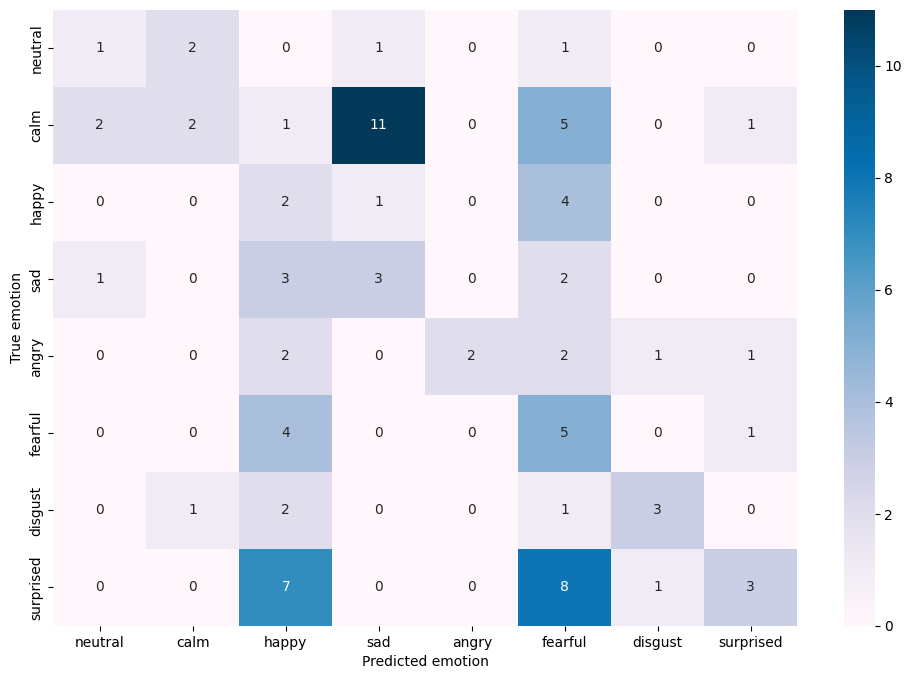

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

y_test_class = y_test
predictions = model.predict(X_test)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

In [ ]:
features_list_2 = []
labels_list_2 = []

for dir in os.listdir(data_path):
    actor = os.listdir(data_path + dir)
    print(f"Directory: {dir}, Number of Files: {len(actor)}")
    for file in actor:
      if file.endswith('.wav'):
        file_path = os.path.join(data_path + dir+ '/'+ file)
        emotion_code = int(file.split('-')[2])-1
        if emotion_code == 2 or emotion_code==3 or emotion_code==6 or emotion_code==7:
          features = extract_features(file_path)
          features_list_2.append(features)
          if emotion_code == 2:
            emotion_code = 0
          elif emotion_code == 3:
            emotion_code = 1
          elif emotion_code == 6:
            emotion_code = 2
          elif emotion_code == 7:
            emotion_code = 3
          labels_list_2.append(emotion_code)

X = np.array(features_list_2)
y = np.array(labels_list_2)

Directory: Actor_24, Number of Files: 60
Directory: Actor_22, Number of Files: 60
Directory: Actor_09, Number of Files: 60
Directory: Actor_01, Number of Files: 60
Directory: Actor_08, Number of Files: 60
Directory: Actor_06, Number of Files: 60
Directory: Actor_07, Number of Files: 60
Directory: Actor_13, Number of Files: 60
Directory: Actor_23, Number of Files: 60
Directory: Actor_19, Number of Files: 60
Directory: Actor_03, Number of Files: 60
Directory: Actor_04, Number of Files: 60
Directory: Actor_15, Number of Files: 60
Directory: Actor_12, Number of Files: 60
Directory: Actor_10, Number of Files: 60
Directory: Actor_21, Number of Files: 60
Directory: Actor_17, Number of Files: 60
Directory: Actor_02, Number of Files: 60
Directory: Actor_05, Number of Files: 60
Directory: Actor_18, Number of Files: 60
Directory: Actor_11, Number of Files: 60
Directory: Actor_16, Number of Files: 60
Directory: Actor_20, Number of Files: 60
Directory: Actor_14, Number of Files: 60


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3))
model.add(LayerNormalization())
model.add(Dense(units=len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
20/20 [==============================] - 5s 71ms/step - loss: 13.7832 - accuracy: 0.2997 - val_loss: 11.1644 - val_accuracy: 0.2897
Epoch 2/100
20/20 [==============================] - 1s 39ms/step - loss: 9.4381 - accuracy: 0.4251 - val_loss: 7.8571 - val_accuracy: 0.3271
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 6.6300 - accuracy: 0.4495 - val_loss: 5.6706 - val_accuracy: 0.2991
Epoch 4/100
20/20 [==============================] - 1s 43ms/step - loss: 4.7436 - accuracy: 0.4935 - val_loss: 4.2561 - val_accuracy: 0.3645
Epoch 5/100
20/20 [==============================] - 1s 41ms/step - loss: 3.5339 - accuracy: 0.5440 - val_loss: 3.3547 - val_accuracy: 0.2710
Epoch 6/100
20/20 [==============================] - 1s 42ms/step - loss: 2.7733 - accuracy: 0.5635 - val_loss: 2.7936 - val_accuracy: 0.2710
Epoch 7/100
20/20 [==============================] - 1s 43ms/step - loss: 2.3510 - accuracy: 0.5000 - val_loss: 2.4288 - val_accuracy: 0.3551
Epoc

4/4 [==============================] - 0s 34ms/step - loss: 2.8834 - accuracy: 0.5047
Validation Loss: 2.8833909034729004, Validation Accuracy: 0.5046728849411011


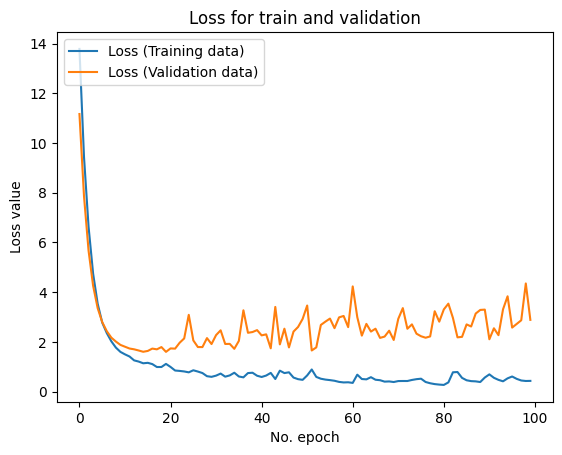

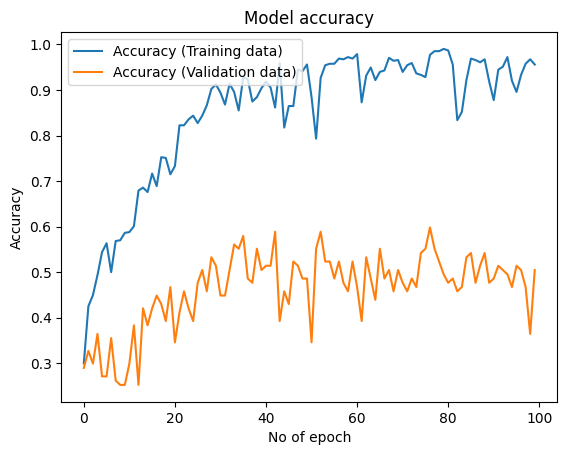

4/4 [==============================] - 1s 13ms/step
Validation set predicted emotions accuracy:
calm : 0.4815
happy : 0.7037
fearful : 0.6000
disgust : 0.3030


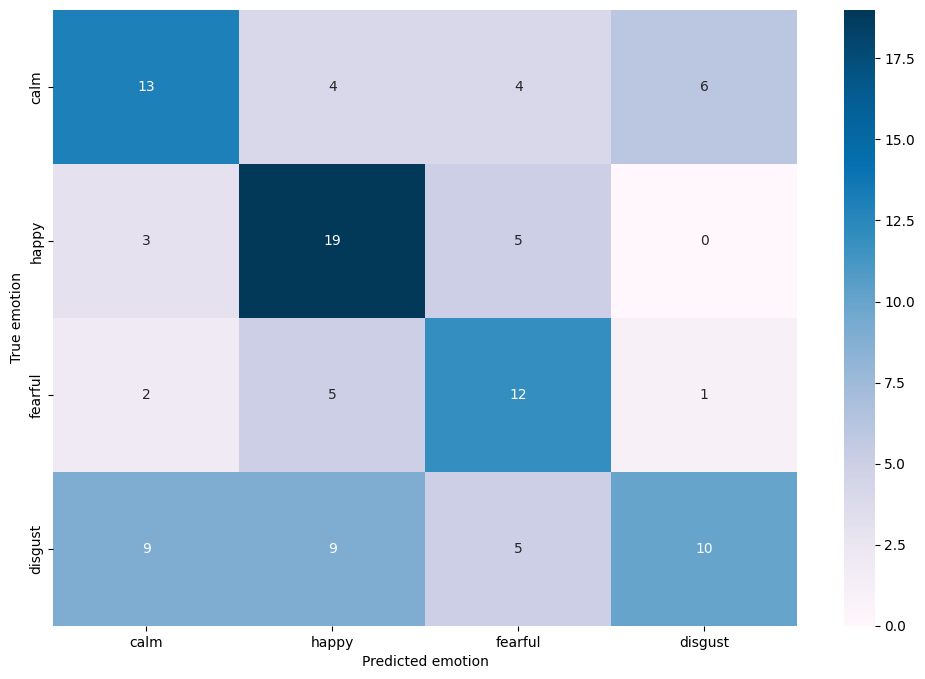

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

plt.plot(history.history['loss'], label='Loss (Training data)')
plt.plot(history.history['val_loss'], label='Loss (Validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


plt.plot(history.history['accuracy'], label='Accuracy (Training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation data)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of epoch')
plt.legend(loc="upper left")
plt.show()


y_val_class = y_val
predictions = model.predict(X_val)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = [ 'calm', 'happy', 'fearful', 'disgust']
columns = [ 'calm', 'happy', 'fearful', 'disgust']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

2/2 [==============================] - 0s 16ms/step - loss: 2.4224 - accuracy: 0.5957
Test Loss: 2.4223930835723877, Test Accuracy: 0.5957446694374084
2/2 [==============================] - 0s 23ms/step
Test set predicted emotions accuracy:
calm : 0.6000
happy : 0.9167
fearful : 0.6429
disgust : 0.3125


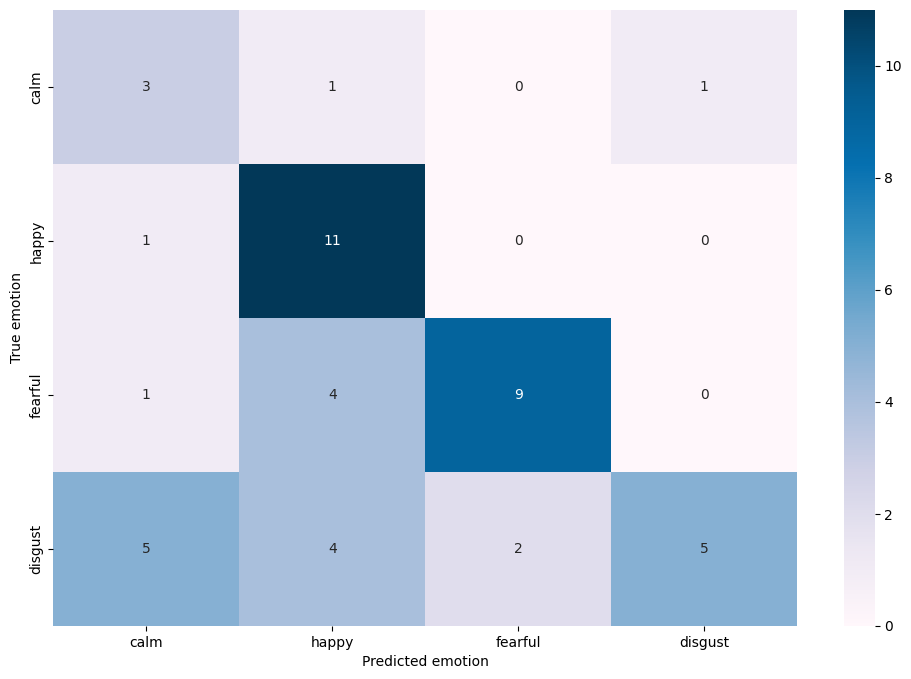

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

y_test_class = y_test
predictions = model.predict(X_test)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = [ 'calm', 'happy', 'fearful', 'disgust']
columns = [ 'calm', 'happy', 'fearful', 'disgust']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

In [ ]:
def trim_silence_and_extract_features(audio,max_length=100):
  y, sr = librosa.load(audio)
  y, index = librosa.effects.trim(y, top_db = 30)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=20)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr,n_bands=6)
  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=20)
  zcr=librosa.feature.zero_crossing_rate(y=y)
  rms=librosa.feature.rms(y=y)
  features = np.vstack([mfcc, chroma, spectral_contrast, mel_spectrogram,zcr,rms])
  padded_features = np.zeros((features.shape[0], max_length))
  padded_features[:, :min(features.shape[1], max_length)] = features[:, :min(features.shape[1], max_length)]
  return padded_features


In [ ]:
features_list_3 = []
labels_list_3 = []

for dir in os.listdir(data_path):
    print(dir)
    actor = os.listdir(data_path + dir)
    num_files = len(actor)
    print(f"Directory: {dir}, Number of Files: {num_files}")
    for file in actor:
      if file.endswith('.wav'):
        file_path = os.path.join(data_path + dir+ '/'+ file)
        emotion_code = int(file.split('-')[2])-1
        if emotion_code == 2 or emotion_code==3 or emotion_code==6 or emotion_code==7:
          features = trim_silence_and_extract_features(file_path)
          features_list_3.append(features)
          if emotion_code == 2:
            emotion_code = 0
          elif emotion_code == 3:
            emotion_code = 1
          elif emotion_code == 6:
            emotion_code = 2
          elif emotion_code == 7:
            emotion_code = 3
          labels_list_3.append(emotion_code)

X = np.array(features_list_3)
y = np.array(labels_list_3)

Actor_24
Directory: Actor_24, Number of Files: 60
Actor_22
Directory: Actor_22, Number of Files: 60
Actor_09
Directory: Actor_09, Number of Files: 60
Actor_01
Directory: Actor_01, Number of Files: 60
Actor_08
Directory: Actor_08, Number of Files: 60
Actor_06
Directory: Actor_06, Number of Files: 60
Actor_07
Directory: Actor_07, Number of Files: 60
Actor_13
Directory: Actor_13, Number of Files: 60
Actor_23
Directory: Actor_23, Number of Files: 60
Actor_19
Directory: Actor_19, Number of Files: 60
Actor_03
Directory: Actor_03, Number of Files: 60
Actor_04
Directory: Actor_04, Number of Files: 60
Actor_15
Directory: Actor_15, Number of Files: 60
Actor_12
Directory: Actor_12, Number of Files: 60
Actor_10
Directory: Actor_10, Number of Files: 60
Actor_21
Directory: Actor_21, Number of Files: 60
Actor_17
Directory: Actor_17, Number of Files: 60
Actor_02
Directory: Actor_02, Number of Files: 60
Actor_05
Directory: Actor_05, Number of Files: 60
Actor_18
Directory: Actor_18, Number of Files: 60


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3))
model.add(LayerNormalization())
model.add(Dense(units=len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
20/20 [==============================] - 5s 79ms/step - loss: 13.5183 - accuracy: 0.3681 - val_loss: 11.1016 - val_accuracy: 0.3925
Epoch 2/100
20/20 [==============================] - 1s 37ms/step - loss: 9.3435 - accuracy: 0.4414 - val_loss: 7.7838 - val_accuracy: 0.3458
Epoch 3/100
20/20 [==============================] - 1s 36ms/step - loss: 6.4780 - accuracy: 0.4805 - val_loss: 5.6020 - val_accuracy: 0.3364
Epoch 4/100
20/20 [==============================] - 1s 37ms/step - loss: 4.6147 - accuracy: 0.5342 - val_loss: 4.1944 - val_accuracy: 0.4299
Epoch 5/100
20/20 [==============================] - 1s 35ms/step - loss: 3.4415 - accuracy: 0.5163 - val_loss: 3.3038 - val_accuracy: 0.4112
Epoch 6/100
20/20 [==============================] - 1s 38ms/step - loss: 2.6758 - accuracy: 0.5423 - val_loss: 2.7078 - val_accuracy: 0.2991
Epoch 7/100
20/20 [==============================] - 1s 38ms/step - loss: 2.1992 - accuracy: 0.5847 - val_loss: 2.3506 - val_accuracy: 0.2897
Epoc

4/4 [==============================] - 0s 12ms/step - loss: 2.6163 - accuracy: 0.5047
Validation Loss: 2.6163008213043213, Validation Accuracy: 0.5046728849411011


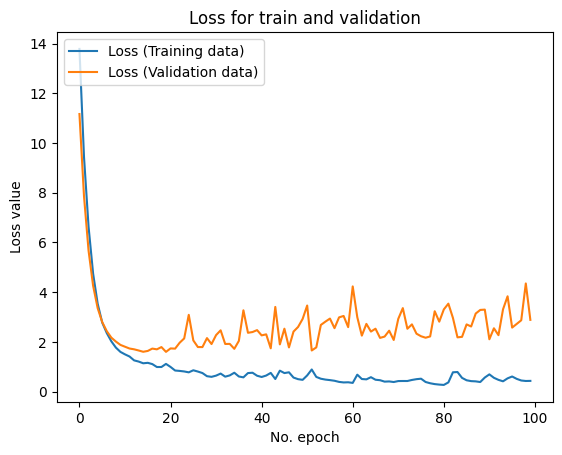

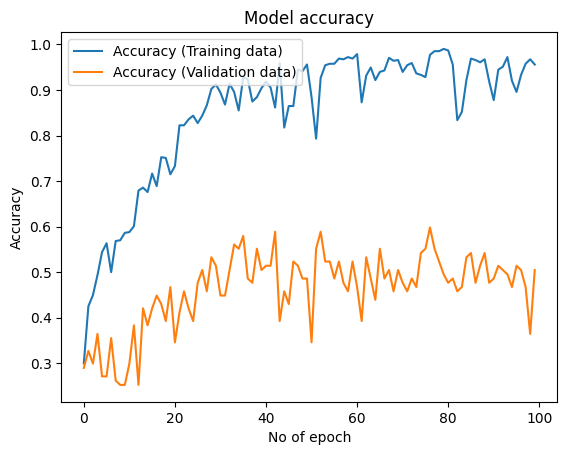

4/4 [==============================] - 1s 13ms/step
Validation set predicted emotions accuracy:
calm : 0.6667
happy : 0.3704
fearful : 0.6000
disgust : 0.4242


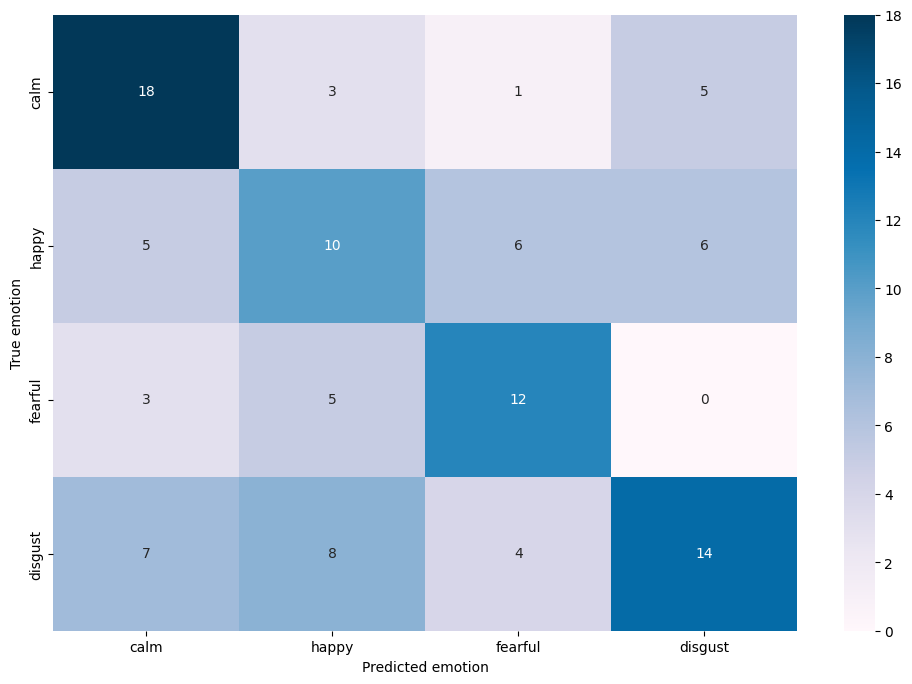

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

plt.plot(history.history['loss'], label='Loss (Training data)')
plt.plot(history.history['val_loss'], label='Loss (Validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


plt.plot(history.history['accuracy'], label='Accuracy (Training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation data)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of epoch')
plt.legend(loc="upper left")
plt.show()


y_val_class = y_val
predictions = model.predict(X_val)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = [ 'calm', 'happy', 'fearful', 'disgust']
columns = [ 'calm', 'happy', 'fearful', 'disgust']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

2/2 [==============================] - 0s 16ms/step - loss: 3.2057 - accuracy: 0.4894
Test Loss: 3.2056760787963867, Test Accuracy: 0.4893617033958435
2/2 [==============================] - 0s 14ms/step
Test set predicted emotions accuracy:
calm : 0.4000
happy : 0.4167
fearful : 0.7143
disgust : 0.3750


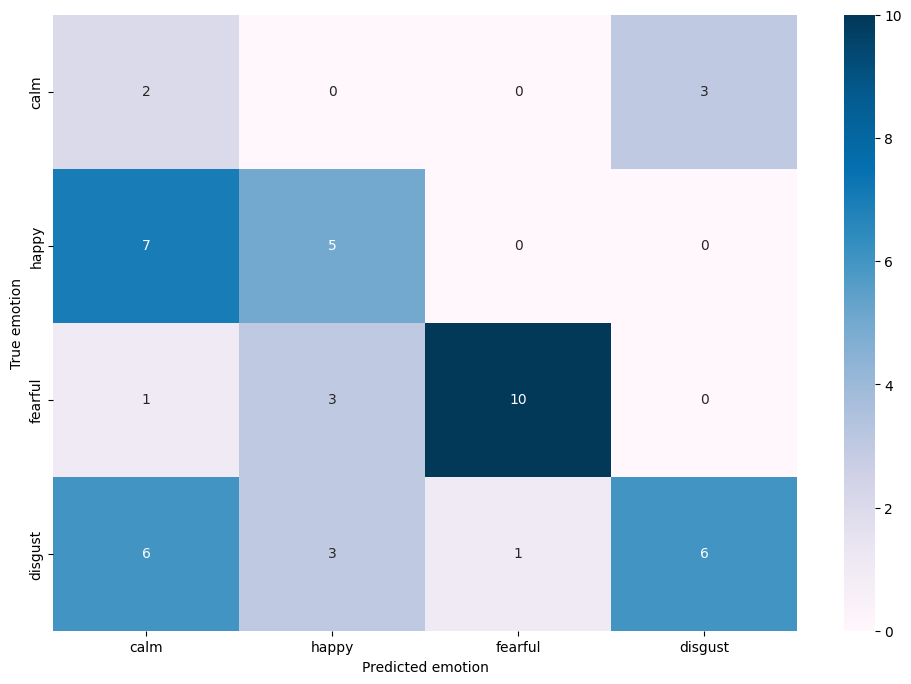

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

y_test_class = y_test
predictions = model.predict(X_test)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = [ 'calm', 'happy', 'fearful', 'disgust']
columns = [ 'calm', 'happy', 'fearful', 'disgust']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

In [ ]:
sample_audio_path='/content/drive/MyDrive/Colab Notebooks/PDS-Project/speech-emotion-recognition-ravdess-data/Actor_01/03-01-08-01-02-01-01.wav'

In [ ]:
def extract_augment_features(file,sr,max_length=100):
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=20)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr,n_bands=6)
  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=20)
  zcr=librosa.feature.zero_crossing_rate(y=y)
  rms=librosa.feature.rms(y=y)
  features = np.vstack([mfcc, chroma, spectral_contrast, mel_spectrogram,zcr,rms])
  padded_features = np.zeros((features.shape[0], max_length))
  padded_features[:, :min(features.shape[1], max_length)] = features[:, :min(features.shape[1], max_length)]
  return padded_features

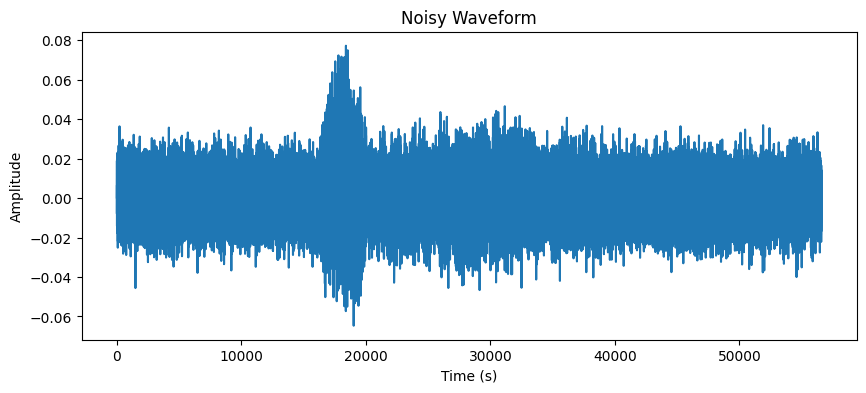

In [ ]:
def noisy_augmentation(file_path):
  y,sr=librosa.load(file_path,sr=None)
  noisy = y + np.random.normal(0, 0.01, len(y))
  feature=extract_augment_features(noisy,sr)
  return feature

y,sr=librosa.load(sample_audio_path,sr=None)
noisy = y + np.random.normal(0, 0.01, len(y))

plt.figure(figsize=(10, 4))
plt.plot(noisy)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy Waveform')
plt.show()

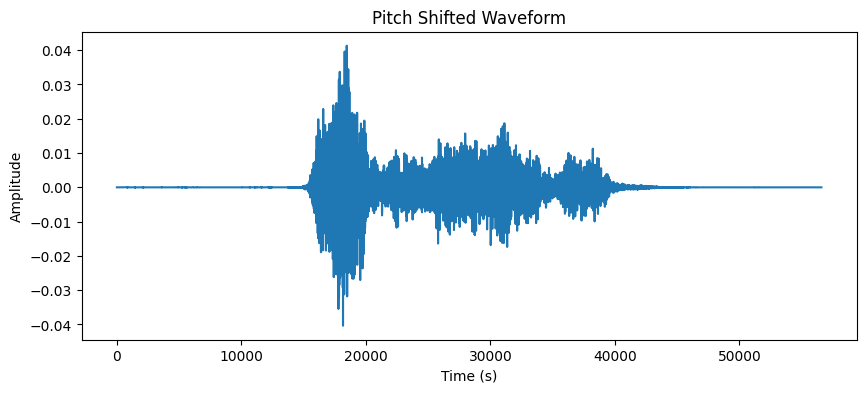

In [ ]:
def pitch_shifted_augmentation(file_path):
  y,sr=librosa.load(file_path,sr=None)
  pitch_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))
  feature=extract_augment_features(pitch_shifted,sr)
  return feature

pitch_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))

plt.figure(figsize=(10, 4))
plt.plot(pitch_shifted)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Pitch Shifted Waveform')
plt.show()

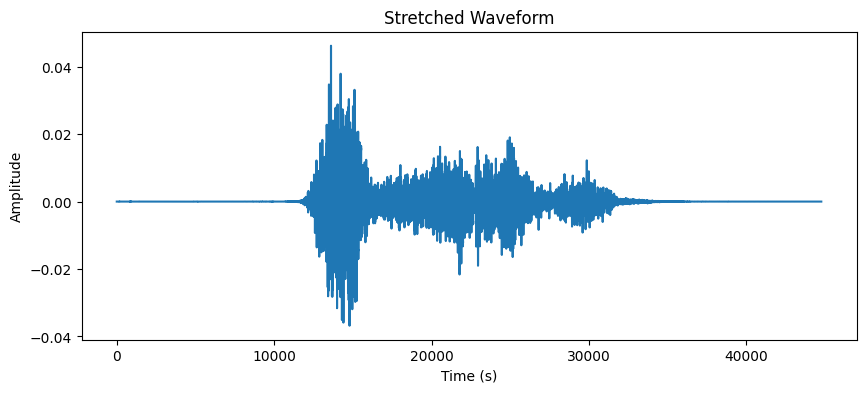

In [ ]:
def stretched_augmentation(file_path):
  y,sr=librosa.load(file_path,sr=None)
  stretch_factor = np.random.uniform(0.7, 1.3)
  stretched = librosa.effects.time_stretch(y, rate=stretch_factor)
  feature=extract_augment_features(stretched,sr)
  return feature

stretch_factor = np.random.uniform(0.7, 1.3)
stretched = librosa.effects.time_stretch(y, rate=stretch_factor)

plt.figure(figsize=(10, 4))
plt.plot(stretched)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Stretched Waveform')
plt.show()

In [ ]:
features_list_4 = []
labels_list_4 = []

for dir in os.listdir(data_path):
    print(dir)
    actor = os.listdir(data_path + dir)
    num_files = len(actor)
    print(f"Directory: {dir}, Number of Files: {num_files}")
    for file in actor:
      if file.endswith('.wav'):
        file_path = os.path.join(data_path + dir+ '/'+ file)
        emotion_code = int(file.split('-')[2])-1
        features = extract_features(file_path)
        features_list_4.append(features)
        labels_list_4.append(emotion_code)
        features_list_4.append(noisy_augmentation(file_path))
        labels_list_4.append(emotion_code)
        features_list_4.append(pitch_shifted_augmentation(file_path))
        labels_list_4.append(emotion_code)
        features_list_4.append(stretched_augmentation(file_path))
        labels_list_4.append(emotion_code)


X = np.array(features_list_4)
y = np.array(labels_list_4)

Actor_24
Directory: Actor_24, Number of Files: 60
Actor_22
Directory: Actor_22, Number of Files: 60
Actor_09
Directory: Actor_09, Number of Files: 60
Actor_01
Directory: Actor_01, Number of Files: 60
Actor_08
Directory: Actor_08, Number of Files: 60
Actor_06
Directory: Actor_06, Number of Files: 60
Actor_07
Directory: Actor_07, Number of Files: 60
Actor_13
Directory: Actor_13, Number of Files: 60
Actor_23
Directory: Actor_23, Number of Files: 60
Actor_19
Directory: Actor_19, Number of Files: 60
Actor_03
Directory: Actor_03, Number of Files: 60
Actor_04
Directory: Actor_04, Number of Files: 60
Actor_15
Directory: Actor_15, Number of Files: 60
Actor_12
Directory: Actor_12, Number of Files: 60
Actor_10
Directory: Actor_10, Number of Files: 60
Actor_21
Directory: Actor_21, Number of Files: 60
Actor_17
Directory: Actor_17, Number of Files: 60
Actor_02
Directory: Actor_02, Number of Files: 60
Actor_05
Directory: Actor_05, Number of Files: 60
Actor_18
Directory: Actor_18, Number of Files: 60


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3))
model.add(LayerNormalization())
model.add(Dense(units=len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
144/144 [==============================] - 19s 116ms/step - loss: 6.3427 - accuracy: 0.1536 - val_loss: 2.4686 - val_accuracy: 0.1452
Epoch 2/100
144/144 [==============================] - 16s 108ms/step - loss: 2.2174 - accuracy: 0.1732 - val_loss: 2.1187 - val_accuracy: 0.1762
Epoch 3/100
144/144 [==============================] - 17s 116ms/step - loss: 2.0776 - accuracy: 0.1727 - val_loss: 2.0700 - val_accuracy: 0.1861
Epoch 4/100
144/144 [==============================] - 15s 107ms/step - loss: 2.0610 - accuracy: 0.1834 - val_loss: 2.0569 - val_accuracy: 0.1700
Epoch 5/100
144/144 [==============================] - 15s 108ms/step - loss: 2.0490 - accuracy: 0.1777 - val_loss: 3.4212 - val_accuracy: 0.1538
Epoch 6/100
144/144 [==============================] - 16s 109ms/step - loss: 2.0376 - accuracy: 0.1853 - val_loss: 2.2818 - val_accuracy: 0.1811
Epoch 7/100
144/144 [==============================] - 16s 112ms/step - loss: 2.0381 - accuracy: 0.1836 - val_loss: 2.3974 -

26/26 [==============================] - 1s 58ms/step - loss: 2.1851 - accuracy: 0.2084
Validation Loss: 2.185107469558716, Validation Accuracy: 0.2084367275238037


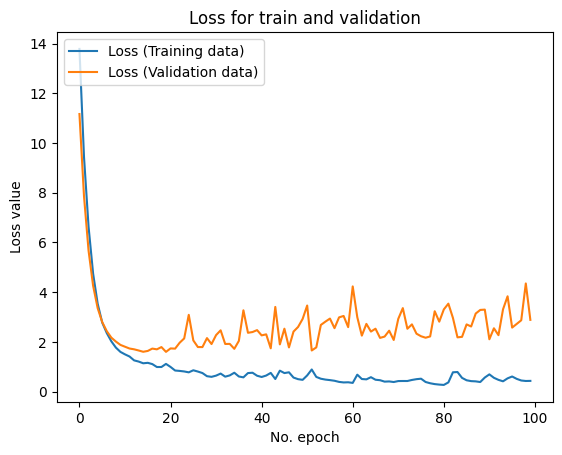

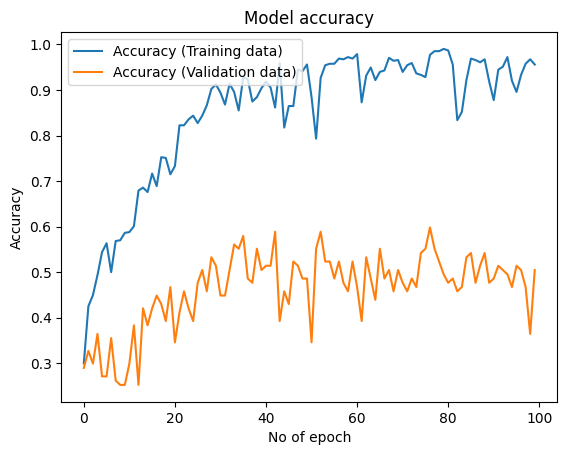

26/26 [==============================] - 2s 40ms/step
Validation set predicted emotions accuracy:
neutral : 0.0588
calm : 0.1215
happy : 0.8824
sad : 0.1111
angry : 0.0755
fearful : 0.1404
disgust : 0.0640
surprised : 0.0430


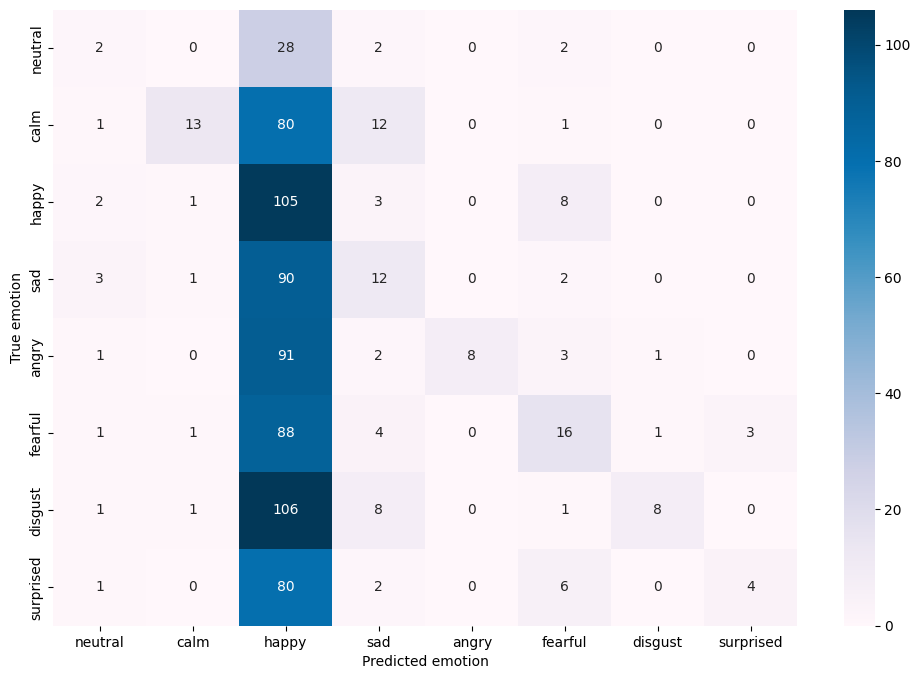

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

plt.plot(history.history['loss'], label='Loss (Training data)')
plt.plot(history.history['val_loss'], label='Loss (Validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


plt.plot(history.history['accuracy'], label='Accuracy (Training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation data)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of epoch')
plt.legend(loc="upper left")
plt.show()

y_val_class = y_val
predictions = model.predict(X_val)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

11/11 [==============================] - 1s 75ms/step - loss: 2.2893 - accuracy: 0.1763
Test Loss: 2.2893195152282715, Test Accuracy: 0.17630058526992798
11/11 [==============================] - 1s 72ms/step
Test set predicted emotions accuracy:
neutral : 0.0000
calm : 0.0556
happy : 0.9130
sad : 0.1795
angry : 0.0800
fearful : 0.0526
disgust : 0.0185
surprised : 0.0465


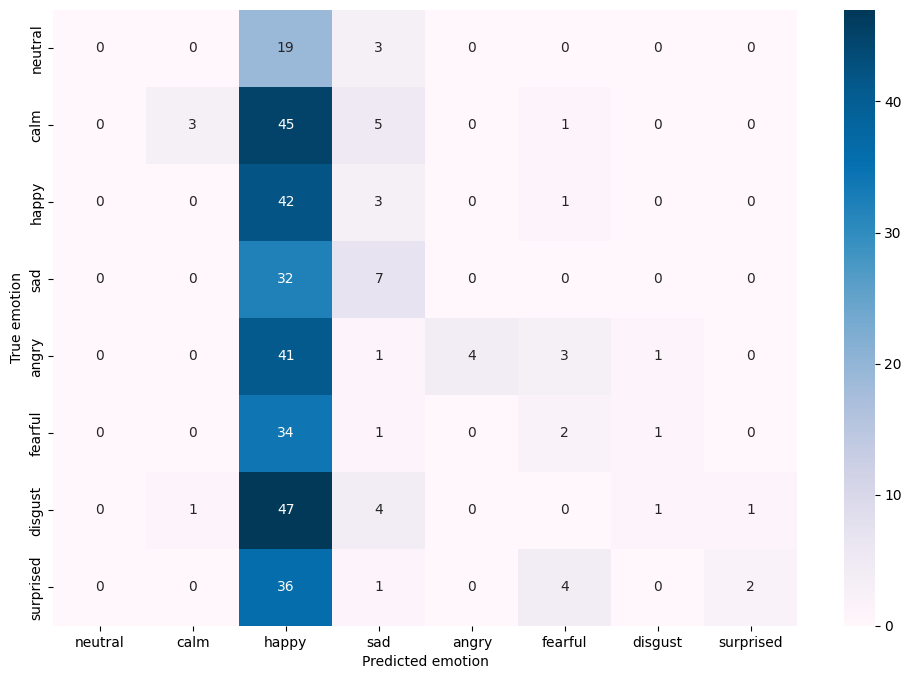

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

y_test_class = y_test
predictions = model.predict(X_test)
y_pred_class = np.argmax(predictions,axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")